### Check the C budget of the spinup runs

In [1]:
from scipy.stats import qmc
import numpy as np
import xarray as xr
import csv
import pandas as pd
import os
import netCDF4 as nc4
import sys
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                     
import shutil                                                                                                                                                       
import tempfile 
import random

#import functions_py.modp as mp
#import fates_xarray_functions as fa

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.colors import BoundaryNorm

dark = cm.get_cmap('Paired', 12)
colormap = dark(range(12))

import functions_py.fates_xarray_functions as fa

/global/homes/j/jneedham/.conda/envs/myenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# this function takes data that has monthly values and returns a single annual value, with 
# a mean that accounts for the number of days per month
def monthly_to_annual(array):
    """ calculate annual mean from monthly data, using unequal month lengths for noleap calendar.  
    originally written by Keith Lindsay."""
    mon_day  = xr.DataArray(np.array([31.,28.,31.,30.,31.,30.,31.,31.,30.,31.,30.,31.]), dims=['month'])
    mon_wgt  = mon_day/mon_day.sum()
    return (array.rolling(time=12, center=False) # rolling
            .construct("month") # construct the array
            .isel(time=slice(11, None, 12)) # slice so that the first element is [1..12], second is [13..24]
            .dot(mon_wgt, dims=["month"]))

In [3]:
# bia spin up
fates = '/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/bia_spinup.E93ab10c892-F53b237c6.2024-05-26/run/bia_spinup.E93ab10c892-F53b237c6.2024-05-26.elm.h0.sofar.nc'
fates = xr.open_dataset(fates,  decode_times=False)

nyears = int(len(fates.variables['time']))

cohort_size_bins = fates.variables['fates_levscls']
patch_age_bins = fates.variables['fates_levage'][:]
nsizebins = len(cohort_size_bins)

time = fates.variables['time'] / 365.

### Carbon 

In [4]:
alloc = (fates.FATES_LEAF_ALLOC_CANOPY_SZ  + fates.FATES_LEAF_ALLOC_USTORY_SZ + 
         fates.FATES_FROOT_ALLOC_CANOPY_SZ  + fates.FATES_FROOT_ALLOC_USTORY_SZ + 
         fates.FATES_SAPWOOD_ALLOC_CANOPY_SZ  + fates.FATES_SAPWOOD_ALLOC_USTORY_SZ + 
         fates.FATES_STORE_ALLOC_CANOPY_SZ  + fates.FATES_STORE_ALLOC_USTORY_SZ +  
         fates.FATES_STRUCT_ALLOC_CANOPY_SZ  + fates.FATES_STRUCT_ALLOC_USTORY_SZ) 
alloc  = alloc.sum(dim='fates_levscls') # kg C m-2 s-1
alloc1 = monthly_to_annual(alloc) * 86400 * 365 # kg C m-2 yr-1

recruit_cflux = monthly_to_annual(fates.FATES_RECRUITMENT_CFLUX_PF.sum(dim='fates_levpft')) 

alloc = alloc1 + recruit_cflux

time_int = np.linspace(1, alloc.shape[0], alloc.shape[0])

In [5]:
# This is mortality * total_m  (leaves,  fineroots, sapwood, storage and structural)
cmort = fates.FATES_MORTALITY_CFLUX_PF 
cmort = cmort.sum(dim='fates_levpft') # kg C m-2 s-1
cmort = monthly_to_annual(cmort)  * 86400 * 365 # kg C m-2 yr-1

turn = (fates.FATES_LEAFCTURN_CANOPY_SZ + fates.FATES_LEAFCTURN_USTORY_SZ + 
        fates.FATES_FROOTCTURN_CANOPY_SZ + fates.FATES_FROOTCTURN_USTORY_SZ + 
        fates.FATES_STORECTURN_CANOPY_SZ + fates.FATES_STORECTURN_USTORY_SZ + 
        fates.FATES_STRUCTCTURN_CANOPY_SZ + fates.FATES_STRUCTCTURN_USTORY_SZ +
        fates.FATES_SAPWOODCTURN_CANOPY_SZ + fates.FATES_SAPWOODCTURN_USTORY_SZ) 
turn = turn.sum(dim='fates_levscls')  # kg C m-2 s-1
turn = monthly_to_annual(turn) * 86400 * 365 # kg C m-2 yr-1

loss = cmort+turn

net = np.cumsum(alloc - loss)


In [6]:
cveg = monthly_to_annual(fates.FATES_VEGC_PF.sum(dim='fates_levpft')) # kg C m-2
cveg_init = fates.FATES_VEGC_PF.sum(dim='fates_levpft')

''

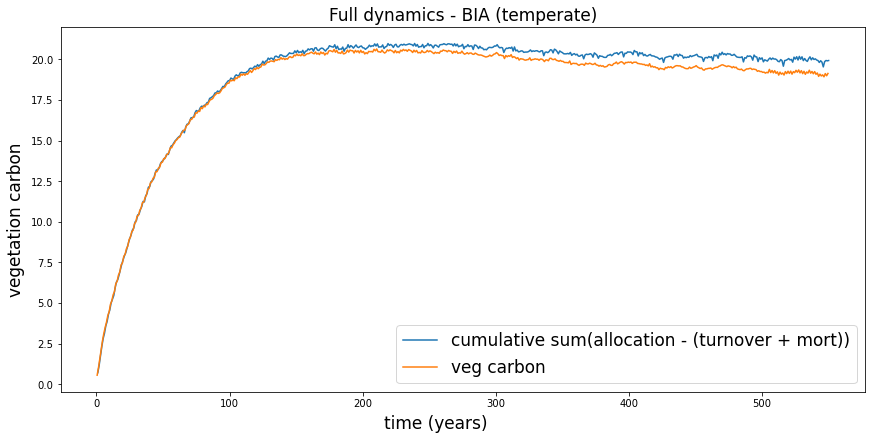

In [7]:
fig1, ((f1ax0)) = plt.subplots(nrows=1,ncols=1, figsize=(12,6), constrained_layout=True)

f1ax0.plot(time_int, net + cveg_init[0], label = 'cumulative sum(allocation - (turnover + mort))')
f1ax0.plot(time_int - 0.5, cveg, label = 'veg carbon')
f1ax0.set_title(r'Full dynamics - BIA (temperate)', fontsize = 17)
f1ax0.legend(fontsize=17)

fig1.supxlabel('time (years)',fontsize=17)
fig1.supylabel('vegetation carbon', fontsize=17)
;

In [8]:
# fi spin up
#fates = '/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/fi_spinup.E93ab10c892-F53b237c6.2024-05-26/run/fi_spinup.E93ab10c892-F53b237c6.2024-05-26.elm.h0.sofar.nc'
fates = '/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/fi_spinup_api30_mort_cflux.E318d6124be-F6215f5bd.2024-06-05/run/fi_spinup_api30_mort_cflux.E318d6124be-F6215f5bd.2024-06-05.elm.h0.sofar.nc'
fates = xr.open_dataset(fates,  decode_times=False)

nyears = int(len(fates.variables['time']))

cohort_size_bins = fates.variables['fates_levscls']
patch_age_bins = fates.variables['fates_levage'][:]
nsizebins = len(cohort_size_bins)

time = fates.variables['time'] / 365.

### Carbon 

In [9]:
alloc = (fates.FATES_LEAF_ALLOC_CANOPY_SZ  + fates.FATES_LEAF_ALLOC_USTORY_SZ + 
         fates.FATES_FROOT_ALLOC_CANOPY_SZ  + fates.FATES_FROOT_ALLOC_USTORY_SZ + 
         fates.FATES_SAPWOOD_ALLOC_CANOPY_SZ  + fates.FATES_SAPWOOD_ALLOC_USTORY_SZ + 
         fates.FATES_STORE_ALLOC_CANOPY_SZ  + fates.FATES_STORE_ALLOC_USTORY_SZ +  
         fates.FATES_STRUCT_ALLOC_CANOPY_SZ  + fates.FATES_STRUCT_ALLOC_USTORY_SZ) 
alloc  = alloc.sum(dim='fates_levscls') # kg C m-2 s-1
alloc1 = monthly_to_annual(alloc) * 86400 * 365 # kg C m-2 yr-1

recruit_cflux = monthly_to_annual(fates.FATES_RECRUITMENT_CFLUX_PF.sum(dim='fates_levpft')) 

alloc = alloc1 + recruit_cflux

time_int = np.linspace(1, alloc.shape[0], alloc.shape[0])

In [10]:
# This is mortality * total_m  (leaves,  fineroots, sapwood, storage and structural)
cmort = fates.FATES_MORTALITY_CFLUX_PF 
cmort = cmort.sum(dim='fates_levpft') # kg C m-2 s-1
cmort = monthly_to_annual(cmort)  * 86400 * 365 # kg C m-2 yr-1

turn = (fates.FATES_LEAFCTURN_CANOPY_SZ + fates.FATES_LEAFCTURN_USTORY_SZ + 
        fates.FATES_FROOTCTURN_CANOPY_SZ + fates.FATES_FROOTCTURN_USTORY_SZ + 
        fates.FATES_STORECTURN_CANOPY_SZ + fates.FATES_STORECTURN_USTORY_SZ + 
        fates.FATES_STRUCTCTURN_CANOPY_SZ + fates.FATES_STRUCTCTURN_USTORY_SZ +
        fates.FATES_SAPWOODCTURN_CANOPY_SZ + fates.FATES_SAPWOODCTURN_USTORY_SZ) 
turn = turn.sum(dim='fates_levscls')  # kg C m-2 s-1
turn = monthly_to_annual(turn) * 86400 * 365 # kg C m-2 yr-1

loss = cmort+turn

net = np.cumsum(alloc - loss)


In [11]:
cveg = monthly_to_annual(fates.FATES_VEGC_PF.sum(dim='fates_levpft')) # kg C m-2
cveg_init = fates.FATES_VEGC_PF.sum(dim='fates_levpft')

''

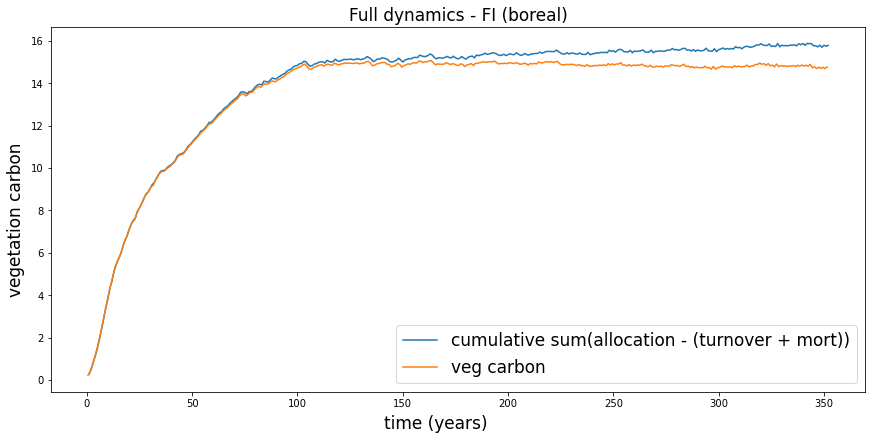

In [12]:
fig1, ((f1ax0)) = plt.subplots(nrows=1,ncols=1, figsize=(12,6), constrained_layout=True)

f1ax0.plot(time_int, net + cveg_init[0], label = 'cumulative sum(allocation - (turnover + mort))')
f1ax0.plot(time_int - 0.5, cveg, label = 'veg carbon')
f1ax0.set_title(r'Full dynamics - FI (boreal)', fontsize = 17)
f1ax0.legend(fontsize=17)

fig1.supxlabel('time (years)',fontsize=17)
fig1.supylabel('vegetation carbon', fontsize=17)
;

In [13]:
# bci spin up
fates = '/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/bci_spinup.E93ab10c892-F53b237c6.2024-05-20/run/bci_spinup.E93ab10c892-F53b237c6.2024-05-20.elm.h0.sofar.nc'
fates = xr.open_dataset(fates,  decode_times=False)

nyears = int(len(fates.variables['time']))

cohort_size_bins = fates.variables['fates_levscls']
patch_age_bins = fates.variables['fates_levage'][:]
nsizebins = len(cohort_size_bins)

time = fates.variables['time'] / 365.

### Carbon 

In [14]:
alloc = (fates.FATES_LEAF_ALLOC_CANOPY_SZ  + fates.FATES_LEAF_ALLOC_USTORY_SZ + 
         fates.FATES_FROOT_ALLOC_CANOPY_SZ  + fates.FATES_FROOT_ALLOC_USTORY_SZ + 
         fates.FATES_SAPWOOD_ALLOC_CANOPY_SZ  + fates.FATES_SAPWOOD_ALLOC_USTORY_SZ + 
         fates.FATES_STORE_ALLOC_CANOPY_SZ  + fates.FATES_STORE_ALLOC_USTORY_SZ +  
         fates.FATES_STRUCT_ALLOC_CANOPY_SZ  + fates.FATES_STRUCT_ALLOC_USTORY_SZ) 
alloc  = alloc.sum(dim='fates_levscls') # kg C m-2 s-1
alloc1 = monthly_to_annual(alloc) * 86400 * 365 # kg C m-2 yr-1

recruit_cflux = monthly_to_annual(fates.FATES_RECRUITMENT_CFLUX_PF.sum(dim='fates_levpft')) 

alloc = alloc1 + recruit_cflux

time_int = np.linspace(1, alloc.shape[0], alloc.shape[0])

In [15]:
# This is mortality * total_m  (leaves,  fineroots, sapwood, storage and structural)
cmort = fates.FATES_MORTALITY_CFLUX_PF 
cmort = cmort.sum(dim='fates_levpft') # kg C m-2 s-1
cmort = monthly_to_annual(cmort)  * 86400 * 365 # kg C m-2 yr-1

turn = (fates.FATES_LEAFCTURN_CANOPY_SZ + fates.FATES_LEAFCTURN_USTORY_SZ + 
        fates.FATES_FROOTCTURN_CANOPY_SZ + fates.FATES_FROOTCTURN_USTORY_SZ + 
        fates.FATES_STORECTURN_CANOPY_SZ + fates.FATES_STORECTURN_USTORY_SZ + 
        fates.FATES_STRUCTCTURN_CANOPY_SZ + fates.FATES_STRUCTCTURN_USTORY_SZ +
        fates.FATES_SAPWOODCTURN_CANOPY_SZ + fates.FATES_SAPWOODCTURN_USTORY_SZ) 
turn = turn.sum(dim='fates_levscls')  # kg C m-2 s-1
turn = monthly_to_annual(turn) * 86400 * 365 # kg C m-2 yr-1

loss = cmort+turn

net = np.cumsum(alloc - loss)


In [16]:
cveg = monthly_to_annual(fates.FATES_VEGC_PF.sum(dim='fates_levpft')) # kg C m-2
cveg_init = fates.FATES_VEGC_PF.sum(dim='fates_levpft')

''

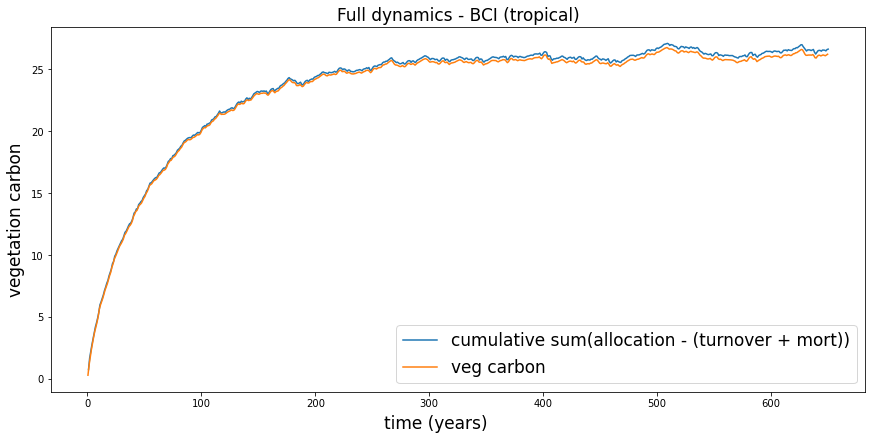

In [17]:
fig1, ((f1ax0)) = plt.subplots(nrows=1,ncols=1, figsize=(12,6), constrained_layout=True)

f1ax0.plot(time_int, net + cveg_init[0], label = 'cumulative sum(allocation - (turnover + mort))')
f1ax0.plot(time_int - 0.5, cveg, label = 'veg carbon')
f1ax0.set_title(r'Full dynamics - BCI (tropical)', fontsize = 17)
f1ax0.legend(fontsize=17)

fig1.supxlabel('time (years)',fontsize=17)
fig1.supylabel('vegetation carbon', fontsize=17)
;